In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from pytorch_metric_learning import distances
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import torchvision
from tqdm.notebook import tqdm


In [2]:
!nvidia-smi

Wed Jul  5 12:03:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.84       Driver Version: 460.84       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   23C    P8     8W / 250W |    447MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

# Data Loading

In [41]:
config = dict(
    saved_path="saved_models/rough1.pt",
    lr=0.001,
    EPOCHS = 5,
    BATCH_SIZE = 16,
    IMAGE_SIZE = 224,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)

random.seed(config['SEED'])
np.random.seed(config['SEED'])
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])

In [42]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAutocontrast(0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [43]:
my_path = 'Subset/'
images = torchvision.datasets.ImageFolder(root=my_path,transform=data_transforms['test'])
print(len(images))

images[1][0].shape, images[1][1]

240


(torch.Size([3, 224, 224]), 0)

In [56]:
import pickle
a_file = open("dataset_50.pkl", "rb")
dataset = pickle.load(a_file)
len(set(dataset['labels'])), len(dataset['labels'])

(50, 597)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


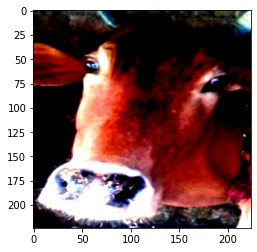

In [64]:
img = np.transpose(dataset['images'][0],(1,2,0))
print(img.shape)
plt.imshow(img)
plt.show()

In [45]:
class Custom_data(Dataset):
    def __init__(self, dataset, n_class = 50, transform = data_transforms, train=True):
        super(Custom_data,self).__init__()
        self.train_transforms = transform['train']
        self.test_transforms = transform['test']
        self.is_train = train
        self.to_pil = transforms.ToPILImage()

        if self.is_train:
            self.images = dataset['images']
            self.labels = np.array(dataset['labels'])
            self.index = np.array(list(range(len(self.labels))))
            self.n_class = n_class

        else:
            self.images = dataset['images']
            self.n_class = 1

    def __len__(self):
        return len(self.images)*(self.n_class-1)

    def __getitem__(self, item):
        item = item//(self.n_class-1)
        anchor_img = self.images[item]

        if self.is_train:
            anchor_label = self.labels[item]
            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item]

            negative_label = item % (self.n_class-1)
            if negative_label>=anchor_label: negative_label+=1
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]==negative_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item]
            if anchor_label==negative_label: print('Error')

            if self.train_transforms:
                anchor_img = self.train_transforms(self.to_pil(anchor_img))
                positive_img = self.train_transforms(self.to_pil(positive_img))
                negative_img = self.train_transforms(self.to_pil(negative_img))

                return anchor_img, positive_img, negative_img, anchor_label

        else:
            if self.transform:
                anchor_img = self.test_transforms(self.to_pil(anchor_img))
            return anchor_img


torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1])


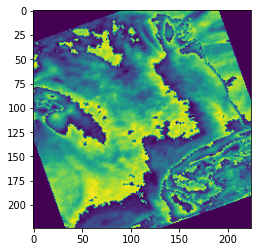

1829

In [51]:
train_ds = Custom_data(dataset, train=True)
train_loader = DataLoader(train_ds, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['num_workers'])
valid_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=config['num_workers'])

a = iter(valid_loader)
b = next(a)
print(b[0].shape, b[1].shape, b[2].shape, b[3].shape)

plt.imshow(b[0][0][2])
plt.show()

len(train_loader)

# Modelling

In [11]:
def train(model,train_loader,criterion,epochs = 10):
    model.train()
    for epoch in range(epochs):
        running_loss = []
        print('Start of Epoch',epoch+1)
        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(train_loader):
            anchor_img = anchor_img.to(config['device'])
            positive_img = positive_img.to(config['device'])
            negative_img = negative_img.to(config['device'])

            optimizer.zero_grad()
            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)

            loss = criterion(anchor_out, positive_out, negative_out)*5
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} -Triplet Loss: {:.3f}".format(epoch+1, epochs, np.mean(running_loss)))
    torch.save(model.state_dict(), config['saved_path'])

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [22]:
efficientnet = models.efficientnet_b0(pretrained = True)
efficientnet.classifier = Identity()

model = efficientnet
#print(model)
model = model.to(config['device'])

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.TripletMarginLoss(margin=2.0)

In [23]:
model.load_state_dict(torch.load('saved_models/rough.pt'))
#train(model,train_loader,criterion, epochs = 2)

<All keys matched successfully>

# GradCAM++

In [35]:
# Define the GradCAM++ function
class GradCAMPP:
    def __init__(self, model):
        self.model = model.eval()
        self.feature_maps = None
        self.gradient_maps = None
        self.target_layer = None
        self.hooks = []

    def _find_target_layer(self):
        def hook(module, input, output):
            self.feature_maps = output.detach()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                self.hooks.append(module.register_forward_hook(hook))
                self.target_layer = name

    def _compute_gradients(self, target_class):
        def hook(module, grad_input, grad_output):
            self.gradient_maps = grad_output[0].detach()

        target = torch.tensor([target_class])
        output = self.model(self.input_image)
        output[:, target].backward()

        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d) and name == self.target_layer:
                self.hooks.append(module.register_backward_hook(hook))

    def _normalize(self, gradient):
        epsilon = 1e-6 / (torch.mean(torch.abs(gradient)) + 1e-6)
        return gradient * epsilon

    def generate_heatmap(self, image, target_class):
        self.input_image = image.requires_grad_(True)
        self._find_target_layer()
        self._compute_gradients(target_class)

        weights = torch.mean(self.gradient_maps, axis=(2, 3), keepdims=True)
        activations = self.feature_maps
        weighted_activations = weights * activations
        heatmap = torch.mean(weighted_activations, axis=1).squeeze()
        heatmap = np.maximum(heatmap, 0)

        heatmap /= torch.max(heatmap)
        heatmap = heatmap.numpy()

        return cv2.resize(heatmap, (image.shape[3], image.shape[2]))

In [37]:
model.to('cpu')
gradcampp = GradCAMPP(model)

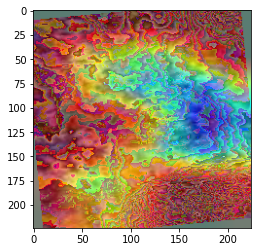

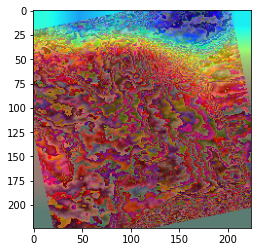

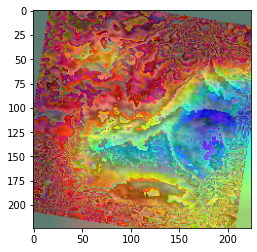

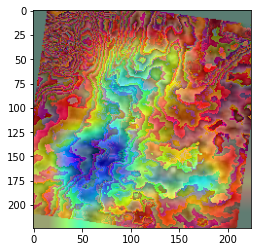

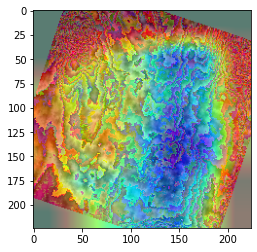

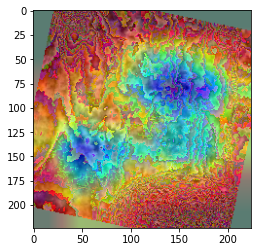

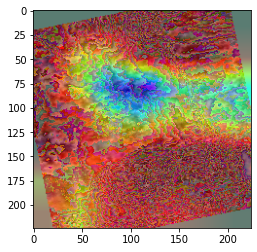

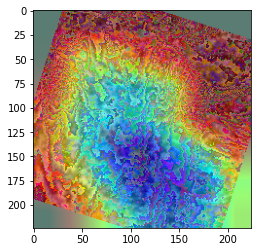

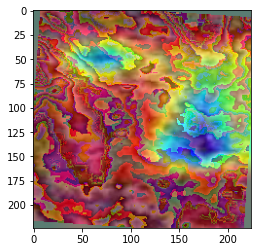

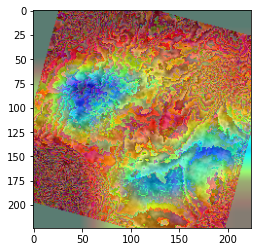

In [52]:
for i in range(10):
    img, pos_image, neg_image, label = next(iter(valid_loader))
    heatmap = gradcampp.generate_heatmap(img, target_class=2)
    # Overlay the heatmap on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    #img = img.detach()
    output_image = cv2.addWeighted(cv2.cvtColor((img.squeeze().detach().numpy() * 255).astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    # Display the result
    plt.imshow(output_image)
    plt.show()

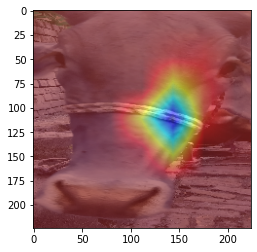

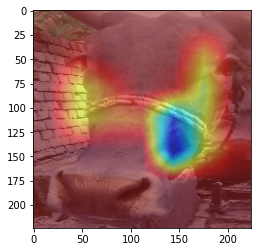

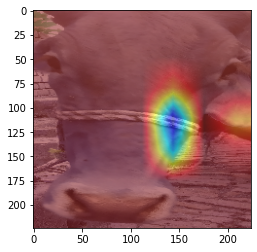

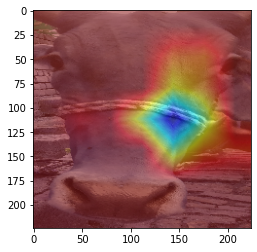

In [55]:
def gradcamheatmap(folder_path):
    for img_name in os.listdir(folder_path):
        # Load a sample image
        image = cv2.imread(folder_path+img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image1 = image
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image).float()

        heatmap = gradcampp.generate_heatmap(image, target_class=2)
        # Overlay the heatmap on the original image
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        output_image = cv2.addWeighted(cv2.cvtColor(image1, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

        # Display the result
        plt.imshow(output_image)
        plt.show()
        
gradcamheatmap("Subset/951/")

In [26]:
device = 'cpu'
model.to(device)
print()

In [15]:
def evaluate(threshold = 2.5):
    pdist = torch.nn.PairwiseDistance(p=2)
    correct = total = 0
    same_class = []
    different_class = []

    model.eval()
    for i in range(25,min(len(images),80)):
        x1 = images[i][0].unsqueeze(0).to(device)
        y1 = model(x1)

        for j in range(i+1, min(len(images), i+6)):
            x2 = images[j][0].unsqueeze(0).to(device)
            y2 = model(x2)

            d = pdist (y1, y2)[0]
            if d<=threshold and images[i][1]==images[j][1]:
                correct += 1
            if d>threshold and images[i][1]!=images[j][1]: correct += 1

            if images[i][1]==images[j][1]:
                same_class.append(d)
            else:
                different_class.append(d)
            total+=1
        #torch.cuda.empty_cache()

    print('Correct',correct, '\n', 'Total', total)
    print(correct/total)
    return (sum(same_class)/len(same_class), sum(different_class)/len(different_class))

evaluate(threshold = 2.8)

Correct 215 
 Total 275
0.7818181818181819


(tensor(1.8982, grad_fn=<DivBackward0>),
 tensor(4.0654, grad_fn=<DivBackward0>))

In [16]:
def angular_evaluation(threshold = 0.90):
    pdist = distances.CosineSimilarity()
    correct = total = 0
    same_class = []
    different_class = []

    model.eval()
    for i in range(45):
        x1 = images[i][0].unsqueeze(0).to(device)
        y1 = model(x1)
        for j in range(i+1, min(len(images), i+8)):
            x2 = images[j][0].unsqueeze(0).to(device)
            y2 = model(x2)

            d = pdist (y1, y2)[0]
            if d>threshold and images[i][1]==images[j][1]:
                correct += 1
            if d<=threshold and images[i][1]!=images[j][1]: correct += 1

            if images[i][1]==images[j][1]:
                same_class.append(d)
            else:
                different_class.append(d)
            total+=1
        #torch.cuda.empty_cache()

    print('Correct',correct, '\n', 'Total', total)
    print(correct/total)
    return (sum(same_class)/len(same_class), sum(different_class)/len(different_class))

angular_evaluation(threshold = 0.91)

Correct 239 
 Total 315
0.7587301587301587


(tensor([0.9693], grad_fn=<DivBackward0>),
 tensor([0.8452], grad_fn=<DivBackward0>))